In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import weibull_dist, make_uniform, make_joint, normalize, update_weibull, plot_contour, plot_lifelines, joint_weibull_mean
from data.utils import make_binomial, make_mixture

In [3]:
lam = 3
k = 0.8
# 책에서는 ss.weibull_min()을 기반하여 새로 함수를 만들었는데, 굳이 새로 만들 필요 없을듯?
# 만든 weibull_dist 대신 ss.weibull_min(k, scale=lam) 활용
actual_dist = ss.weibull_min(k, scale=lam)
data = actual_dist.rvs(10)
data

array([10.36473302,  3.70469463,  0.0945789 ,  0.55446506,  1.64430122,
        0.15146922,  0.01429561,  4.71309282,  2.08518422,  3.06893012])

In [4]:
lams = np.linspace(0.1, 10.1, 101)
ks = np.linspace(0.1, 5.1, 101)
prior_lam = make_uniform(lams, name='lambda')
prior_k = make_uniform(ks, name='k')
prior = make_joint(prior_lam, prior_k)
prior

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,...,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,10.1
0.10,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.15,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.20,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.30,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.90,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
4.95,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.05,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


In [5]:
lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
densities = ss.weibull_min(k_mesh, scale=lam_mesh).pdf(data_mesh)
likelihood = densities.prod(axis=2)

In [6]:
posterior = prior * likelihood
normalize(posterior)
posterior

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,...,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,10.1
0.10,4.950859e-09,5.766912e-09,6.140363e-09,6.347600e-09,6.472377e-09,6.550027e-09,6.598298e-09,6.627144e-09,6.642596e-09,6.648516e-09,...,5.321065e-09,5.309748e-09,5.298528e-09,5.287402e-09,5.276368e-09,5.265426e-09,5.254575e-09,5.243812e-09,5.233136e-09,5.222547e-09
0.15,1.460844e-07,2.135476e-07,2.496497e-07,2.713394e-07,2.851370e-07,2.941487e-07,3.000574e-07,3.038570e-07,3.061729e-07,3.074172e-07,...,1.964913e-07,1.956293e-07,1.947765e-07,1.939329e-07,1.930982e-07,1.922723e-07,1.914550e-07,1.906463e-07,1.898459e-07,1.890538e-07
0.20,9.228245e-07,1.948331e-06,2.647643e-06,3.120744e-06,3.445213e-06,3.669634e-06,3.824684e-06,3.930361e-06,4.000132e-06,4.043333e-06,...,1.986064e-06,1.971793e-06,1.957716e-06,1.943829e-06,1.930127e-06,1.916608e-06,1.903267e-06,1.890102e-06,1.877108e-06,1.864284e-06
0.25,1.975080e-06,7.206905e-06,1.222811e-05,1.624551e-05,1.929729e-05,2.156602e-05,2.322766e-05,2.442414e-05,2.526440e-05,2.583096e-05,...,9.580021e-06,9.480478e-06,9.382605e-06,9.286362e-06,9.191713e-06,9.098622e-06,9.007053e-06,8.916972e-06,8.828345e-06,8.741142e-06
0.30,1.660072e-06,1.315019e-05,3.044392e-05,4.780083e-05,6.290840e-05,7.522724e-05,8.490147e-05,9.228961e-05,9.778096e-05,1.017300e-04,...,2.846856e-05,2.807268e-05,2.768484e-05,2.730480e-05,2.693238e-05,2.656736e-05,2.620956e-05,2.585880e-05,2.551488e-05,2.517764e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.90,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.255739e-39,4.699317e-39,3.043004e-39,1.970670e-39,1.276689e-39,8.276005e-40,5.369257e-40,3.486983e-40,2.267269e-40,1.476188e-40
4.95,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.431466e-39,1.568487e-39,1.011521e-39,6.523549e-40,4.208514e-40,2.716551e-40,1.754883e-40,1.134769e-40,7.346381e-41,4.762300e-41
5.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.138572e-40,5.229106e-40,3.358562e-40,2.157075e-40,1.385760e-40,8.907053e-41,5.729336e-41,3.688835e-41,2.377772e-41,1.534688e-41
5.05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.721020e-40,1.741344e-40,1.113906e-40,7.124726e-41,4.557986e-41,2.917290e-41,1.868498e-41,1.197860e-41,7.687831e-42,4.940394e-42


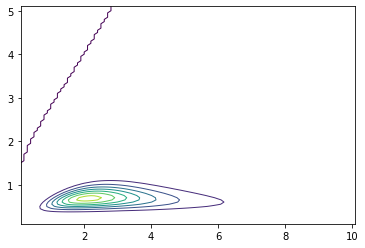

In [7]:
posterior = update_weibull(prior, data)
plot_contour(posterior)

In [8]:
start = np.random.uniform(0, 8, size=10)
start

array([1.06629506, 3.671321  , 2.84218471, 1.13406594, 5.88184244,
       1.38561919, 6.50305224, 2.267052  , 6.16771186, 1.73852413])

In [9]:
duration = actual_dist.rvs(10)
duration

array([ 0.76964323,  5.47372481,  0.7926791 ,  1.97884916,  0.68567666,
        0.28945283,  1.72186762, 15.59582102,  3.10719459,  0.14992487])

In [12]:
obs = pd.DataFrame(dict(start=start, end=start+duration)).sort_values(by='start', ignore_index=True)
obs

,start,end
0,1.066295,1.835938
1,1.134066,3.112915
2,1.385619,1.675072
3,1.738524,1.888449
4,2.267052,17.862873
5,2.842185,3.634864
6,3.671321,9.145046
7,5.881842,6.567519
8,6.167712,9.274906
9,6.503052,8.224920


In [13]:
censored = obs['end'] > 8
obs.loc[censored, 'end'] = 8
obs.loc[censored, 'status'] = 0
obs['T'] = obs['end'] - obs['start']
obs

,start,end,status,T
0,1.066295,1.835938,NaN,0.769643
1,1.134066,3.112915,NaN,1.978849
2,1.385619,1.675072,NaN,0.289453
3,1.738524,1.888449,NaN,0.149925
4,2.267052,8.000000,0.0,5.732948
5,2.842185,3.634864,NaN,0.792679
6,3.671321,8.000000,0.0,4.328679
7,5.881842,6.567519,NaN,0.685677
8,6.167712,8.000000,0.0,1.832288
9,6.503052,8.000000,0.0,1.496948


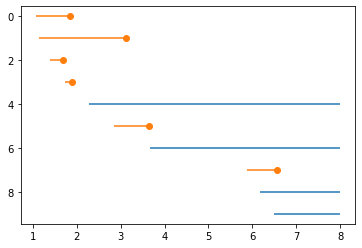

In [14]:
plot_lifelines(obs)

In [15]:
data1 = obs.loc[~censored, 'T']
data2 = obs.loc[censored, 'T']

In [16]:
posterior1 = update_weibull(prior, data1)
posterior2 = update_weibull(posterior1, data2, complete=False)

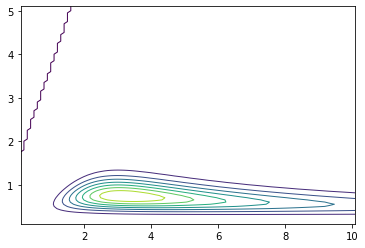

In [17]:
plot_contour(posterior2)

In [18]:
posterior_lam1 = Pmf(posterior1.stack()).marginal(1)
posterior_k1 = Pmf(posterior1.stack()).marginal(0)
posterior_lam2 = Pmf(posterior2.stack()).marginal(1)
posterior_k2 = Pmf(posterior2.stack()).marginal(0)

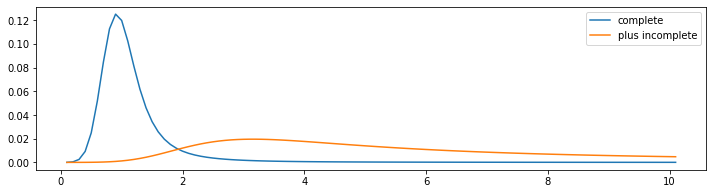

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
posterior_lam1.plot(ax=ax, label='complete')
posterior_lam2.plot(ax=ax, label='plus incomplete')
plt.legend()
plt.show()

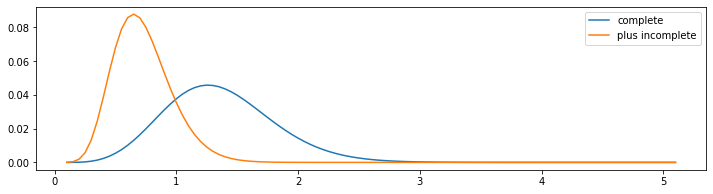

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
posterior_k1.plot(ax=ax, label='complete')
posterior_k2.plot(ax=ax, label='plus incomplete')
plt.legend()
plt.show()

In [22]:
df = pd.read_csv(Path.cwd() / 'data' / 'lamps.csv')
df.head()

,i,h,f,K
0,0,0,0,50
1,1,840,2,48
2,2,852,1,47
3,3,936,1,46
4,4,960,1,45


In [23]:
pmf_bulb = Pmf(df['f'].to_numpy(), df['h'])
pmf_bulb.normalize()

50

In [25]:
pmf_bulb.head(5)

,probs
h,
0,0.00
840,0.04
852,0.02
936,0.02
960,0.02


In [26]:
lams = np.linspace(1000, 2000, 101)
ks = np.linspace(1, 10, 101)
prior_lam = make_uniform(lams, name='lambda')
prior_k = make_uniform(ks, name='k')
prior_bulb = make_joint(prior_lam, prior_k)
prior_bulb

,1000.0,1010.0,1020.0,1030.0,1040.0,1050.0,1060.0,1070.0,1080.0,1090.0,...,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0
1.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
1.09,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
1.18,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
1.27,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
1.36,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.64,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
9.73,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
9.82,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
9.91,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


In [29]:
# df['h']에 있는 내용을 df['f']만큼 반복 → 50개의 주기를 만들기 위해
data_bulb = np.repeat(df['h'], df['f'])
len(data_bulb)

50

In [30]:
posterior_bulb = update_weibull(prior_bulb, data_bulb)
posterior_bulb

,1000.0,1010.0,1020.0,1030.0,1040.0,1050.0,1060.0,1070.0,1080.0,1090.0,...,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0
1.00,2.036691e-25,2.493608e-25,3.026215e-25,3.641430e-25,4.345817e-25,5.145403e-25,6.045504e-25,7.050539e-25,8.163873e-25,9.387655e-25,...,7.664857e-25,7.158618e-25,6.681529e-25,6.232343e-25,5.809822e-25,5.412741e-25,5.039895e-25,4.690099e-25,4.362199e-25,4.055067e-25
1.09,5.449887e-24,6.974544e-24,8.829718e-24,1.106231e-23,1.372052e-23,1.685283e-23,2.050682e-23,2.472783e-23,2.955764e-23,3.503302e-23,...,3.121966e-23,2.883225e-23,2.660767e-23,2.453702e-23,2.261164e-23,2.082312e-23,1.916334e-23,1.762446e-23,1.619898e-23,1.487970e-23
1.18,9.191480e-23,1.236524e-22,1.641861e-22,2.152736e-22,2.788439e-22,3.569719e-22,4.518437e-22,5.657118e-22,7.008409e-22,8.594456e-22,...,8.700562e-22,7.940719e-22,7.241106e-22,6.597702e-22,6.006662e-22,5.464319e-22,4.967190e-22,4.511975e-22,4.095553e-22,3.714987e-22
1.27,1.020933e-21,1.452568e-21,2.034589e-21,2.807158e-21,3.817195e-21,5.118430e-21,6.771139e-21,8.841536e-21,1.140078e-20,1.452356e-20,...,1.747735e-20,1.575452e-20,1.418797e-20,1.276534e-20,1.147501e-20,1.030609e-20,9.248370e-21,8.292360e-21,7.429216e-21,6.650738e-21
1.36,7.720367e-21,1.169270e-20,1.738347e-20,2.538648e-20,3.644182e-20,5.145211e-20,7.149478e-20,9.782829e-20,1.318906e-19,1.752880e-19,...,2.638086e-19,2.347512e-19,2.086715e-19,1.852970e-19,1.643753e-19,1.456736e-19,1.289775e-19,1.140900e-19,1.008310e-19,8.903585e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.64,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.019929e-32,2.900361e-33,7.807714e-34,1.997365e-34,4.873211e-35,1.137782e-35,2.550092e-36,5.502813e-37,1.146417e-37,2.311798e-38
9.73,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.465081e-33,7.063749e-34,1.912073e-34,4.908859e-35,1.199752e-35,2.801296e-36,6.269106e-37,1.348845e-37,2.798161e-38,5.611800e-39
9.82,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.850465e-34,1.691105e-34,4.607380e-35,1.188109e-35,2.911206e-36,6.802808e-37,1.521188e-37,3.265433e-38,6.749266e-39,1.346916e-39
9.91,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.363156e-34,3.978967e-35,1.092192e-35,2.831542e-36,6.961596e-37,1.629319e-37,3.642970e-38,7.807243e-39,1.608712e-39,3.196358e-40


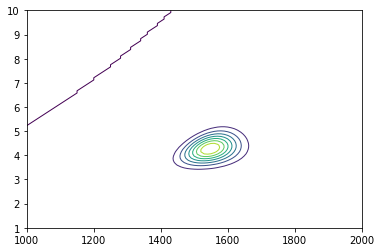

In [31]:
plot_contour(posterior_bulb)

In [34]:
lam_mesh, k_mesh = np.meshgrid(prior_bulb.columns, prior_bulb.index)
means = ss.weibull_min(k_mesh, scale=lam_mesh).mean()
# posterior mean을 위한 weibull distribution의 parameter별 평균
pd.DataFrame(means, columns=prior_bulb.columns, index=prior_bulb.index)

,1000.0,1010.0,1020.0,1030.0,1040.0,1050.0,1060.0,1070.0,1080.0,1090.0,...,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0
1.00,1000.000000,1010.000000,1020.000000,1030.000000,1040.000000,1050.000000,1060.000000,1070.000000,1080.000000,1090.000000,...,1910.000000,1920.000000,1930.000000,1940.000000,1950.000000,1960.000000,1970.000000,1980.000000,1990.000000,2000.000000
1.09,967.856502,977.535067,987.213632,996.892197,1006.570762,1016.249327,1025.927892,1035.606457,1045.285022,1054.963587,...,1848.605919,1858.284484,1867.963049,1877.641614,1887.320179,1896.998744,1906.677309,1916.355874,1926.034439,1935.713004
1.18,944.841470,954.289885,963.738300,973.186714,982.635129,992.083544,1001.531959,1010.980373,1020.428788,1029.877203,...,1804.647208,1814.095623,1823.544038,1832.992452,1842.440867,1851.889282,1861.337696,1870.786111,1880.234526,1889.682941
1.27,928.100129,937.381130,946.662132,955.943133,965.224134,974.505135,983.786137,993.067138,1002.348139,1011.629141,...,1772.671246,1781.952248,1791.233249,1800.514250,1809.795251,1819.076253,1828.357254,1837.638255,1846.919257,1856.200258
1.36,915.799798,924.957796,934.115794,943.273792,952.431790,961.589788,970.747786,979.905784,989.063782,998.221780,...,1749.177615,1758.335613,1767.493611,1776.651609,1785.809607,1794.967605,1804.125603,1813.283601,1822.441599,1831.599597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.64,949.855938,959.354497,968.853057,978.351616,987.850175,997.348735,1006.847294,1016.345853,1025.844413,1035.342972,...,1814.224841,1823.723401,1833.221960,1842.720519,1852.219079,1861.717638,1871.216198,1880.714757,1890.213316,1899.711876
9.73,950.237983,959.740363,969.242743,978.745123,988.247503,997.749883,1007.252262,1016.754642,1026.257022,1035.759402,...,1814.954548,1824.456928,1833.959308,1843.461688,1852.964068,1862.466448,1871.968827,1881.471207,1890.973587,1900.475967
9.82,950.614391,960.120535,969.626679,979.132823,988.638967,998.145111,1007.651255,1017.157399,1026.663543,1036.169687,...,1815.673488,1825.179632,1834.685776,1844.191919,1853.698063,1863.204207,1872.710351,1882.216495,1891.722639,1901.228783
9.91,950.985281,960.495134,970.004987,979.514840,989.024693,998.534546,1008.044398,1017.554251,1027.064104,1036.573957,...,1816.381888,1825.891740,1835.401593,1844.911446,1854.421299,1863.931152,1873.441005,1882.950857,1892.460710,1901.970563


In [35]:
# 평균과 확률을 곱한 기대값 → posterior mean
prod = means * posterior_bulb
prod.sum().sum()

1412.7242773758674

In [36]:
joint_weibull_mean(posterior_bulb)

1412.7242773758671

In [37]:
# k가 4, lambda가 1550이라고 배치, 1000시간 후 확인하러 돌아왔을 때 전구가 나가있을 확률
lam = 1550
k = 4
t = 1000
prob_dead = ss.weibull_min(k, scale=lam).cdf(t)
prob_dead

0.15907263121072054

In [40]:
# 전구가 나가있을 확률 p를 안다면, 나간 전구의 수는 이항분포를 따름
t = 1000
n = 100
pmf_seq = []
for (k, lam) in posterior_bulb.stack().index:
    prob_dead = ss.weibull_min(k, scale=lam).cdf(t)
    pmf = make_binomial(n, prob_dead)
    pmf_seq.append(pmf)

post_pred = make_mixture(posterior_bulb.stack(), pmf_seq)
post_pred

,probs
0,2.160056e-05
1,1.752240e-04
2,7.492730e-04
3,2.246610e-03
4,5.302288e-03
...,...
96,2.183673e-31
97,1.384322e-32
98,6.571840e-34
99,2.075257e-35


<AxesSubplot:>

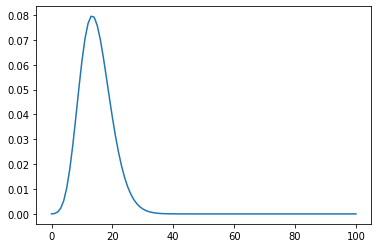

In [41]:
post_pred.plot()